In [19]:
#install.packages("DBI")
#install.packages("RPostgres")
#install.packages("dplyr")
#install.packages("DescTools")
#install.packages("tidyr")
#install.packages("tidyverse")
#install.packages("RSQLite")
#install.packages("lubridate")
#install.packages("ggplot2")
#install.packages("tidyfinance")
#install.packages("DescTools")

In [20]:
library(DBI)
library(RPostgres)
library(dplyr)
library(DescTools)  
library(tidyr)
library(tidyverse)
library(RSQLite)
library(lubridate)
library(ggplot2)
library(tidyfinance)
library(DescTools)

# Set up WRDS connection
wrds_host <- "wrds-pgdata.wharton.upenn.edu"  
wrds_user <- "@user@"                 
wrds_password <- "@password@"              

# Connect to WRDS
wrds_conn <- dbConnect(
  Postgres(),
  host = wrds_host,
  port = 9737,              
  dbname = "wrds",          
  user = wrds_user,
  password = wrds_password,
  sslmode = "require"      
)

# Test the connection
if (dbIsValid(wrds_conn)) {
  print("Connection successful!")
} else {
  print("Connection failed!")
}

[1] "Connection successful!"


In [21]:
# CRSP: Monthly stock returns, market cap, etc.
crsp_query <- "
  SELECT permno, date, ret, prc, shrout
  FROM crsp.dsf
  WHERE date BETWEEN '2000-01-01' AND '2020-12-31'
  LIMIT 1000;
"

# Fetch the data into R as a data frame
crsp_data <- dbGetQuery(wrds_conn, crsp_query)

#head(crsp_data)

In [22]:
# Compustat: Firm-level financial data
compustat_query <- "
  SELECT f.gvkey, f.fyear, f.at, f.sale, f.prcc_f, f.csho, c.sic
  FROM comp.funda f
  JOIN comp.company c ON f.gvkey = c.gvkey
  WHERE f.fyear BETWEEN 2000 AND 2020
  LIMIT 1000;
"

# Fetch the data into R as a data frame
compustat_data <- dbGetQuery(wrds_conn, compustat_query)

#head(compustat_data)

In [23]:
# Profitability Anomaly - High ROA firms outperform low ROA firms
compustat_data <- compustat_data %>%
  mutate(profitability = at / sale)  # ROA

profit_cutoff <- quantile(compustat_data$profitability, 0.8, na.rm = TRUE)  # Top 20% are High Profit
compustat_data$profit_group <- ifelse(compustat_data$profitability >= profit_cutoff, "High", "Low")

#head(compustat_data$profit_group)
#head(compustat_data$profitability)

In [24]:
# Size Anomaly - prc (price) and shrout (shares outstanding)
crsp_data$size <- abs(crsp_data$prc) * crsp_data$shrout

# Classify firms into Small and Large based on size
size_cutoff <- quantile(crsp_data$size, 0.8, na.rm = TRUE)
crsp_data$large_stocks <- ifelse(crsp_data$size >= size_cutoff, "Large", "Small")

#head(crsp_data$size)
#head(crsp_data$large_stocks)

In [25]:
# Value Anomaly using Book-to-Market ratio
compustat_data$value <- compustat_data$at / compustat_data$sale

# Classify firms into Value (high B/M) and Growth (low B/M)
value_cutoff <- quantile(compustat_data$value, 0.8, na.rm = TRUE)
compustat_data$value_group <- ifelse(compustat_data$value >= value_cutoff, "Value", "Growth")

#head(compustat_data$value)
#head(compustat_data$value_group)

In [26]:
# Filter for Manufacturing firms
Manufacturing_data <- compustat_data %>%
  filter(sic >= 2000 & sic <= 3999)

#head(Manufacturing_data)

In [27]:
# Function to apply winsorization (limits values to the specified percentile range)
winsorize <- function(x, lower = 0.05, upper = 0.95) {
  lower_bound <- quantile(x, lower, na.rm = TRUE)
  upper_bound <- quantile(x, upper, na.rm = TRUE)
  
  x <- pmax(x, lower_bound)  # Replace values below the lower bound
  x <- pmin(x, upper_bound)  # Replace values above the upper bound
  
  return(x)
}

In [28]:
# Apply Winsorization to the momentum, size, and value variables
compustat_data$profitability <- winsorize(compustat_data$profitability, lower = 0.05, upper = 0.95)
crsp_data$size <- winsorize(crsp_data$size, lower = 0.05, upper = 0.95)
compustat_data$value <- winsorize(compustat_data$value, lower = 0.05, upper = 0.95)

In [29]:
# URL for the Fama-French 5 Factors (Monthly)
url <- "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
temp_file <- tempfile()
download.file(url, temp_file, quiet = TRUE)

# Extract & read the CSV file
csv_file <- unzip(temp_file, list = TRUE)$Name[1]
ff5_data <- read.csv(unz(temp_file, csv_file), skip = 2, header = TRUE, stringsAsFactors = FALSE)
unlink(temp_file)

# Convert the first column (date) to a proper date format
ff5_data <- ff5_data %>%
  rename(date_str = `X`) %>% # Rename the first column 
  mutate(date = as.Date(paste0(date_str, "01"), format = "%Y%m%d")) %>% # Convert to date
  select(-date_str) %>% # Remove the original string date column
  filter(date >= "2000-01-01" & date <= "2020-12-31") 

#head(ff5_data)

In [30]:
#Merge specific stock data with Fama-French control factors
ff5_data <- ff5_data %>%
  mutate(fyear = as.integer(format(as.Date(date), "%Y")))

merged_data <- left_join(Manufacturing_data, ff5_data, by = "fyear", relationship = "many-to-many")

# Ensure all relevant factors are numeric and handle NAs
merged_data <- merged_data %>%
  mutate(across(c(Mkt.RF, SMB, HML, RMW, CMA, RF), as.numeric)) %>%
  drop_na(Mkt.RF, SMB, HML, RMW, CMA)  # Ensure no missing values

#head(merged_data, 100)

In [31]:
# Ensure Mkt.RF is numeric and handle NAs
merged_data <- merged_data %>%
  mutate(Mkt.RF = as.numeric(Mkt.RF)) %>%  # Ensure Mkt.RF is numeric
  filter(!is.na(Mkt.RF))  # Remove rows with NA in Mkt.RF (or handle NAs as needed)

# Profitability strategy (long high-profit firms, short low-profit firms)
merged_data <- merged_data %>%
  mutate(profitability_ret = ifelse(profit_group == "High", Mkt.RF + RMW, -(Mkt.RF + RMW)))

# Size strategy (long large stocks, short small stocks)
merged_data <- merged_data %>%
  mutate(size_ret = ifelse(value_group == "Large", Mkt.RF + SMB, -(Mkt.RF + SMB)))

# Value strategy (long value stocks, short growth stocks)
merged_data <- merged_data %>%
  mutate(value_ret = ifelse(value_group == "Value", Mkt.RF + HML, -(Mkt.RF + HML)))

# 3. Calculate cumulative returns for each strategy
merged_data <- merged_data %>%
  arrange(date) %>%
  mutate(
    profitability_cum_ret = cumprod(1 + profitability_ret) - 1,
    size_cum_ret = cumprod(1 + size_ret) - 1,
    value_cum_ret = cumprod(1 + value_ret) - 1
  )

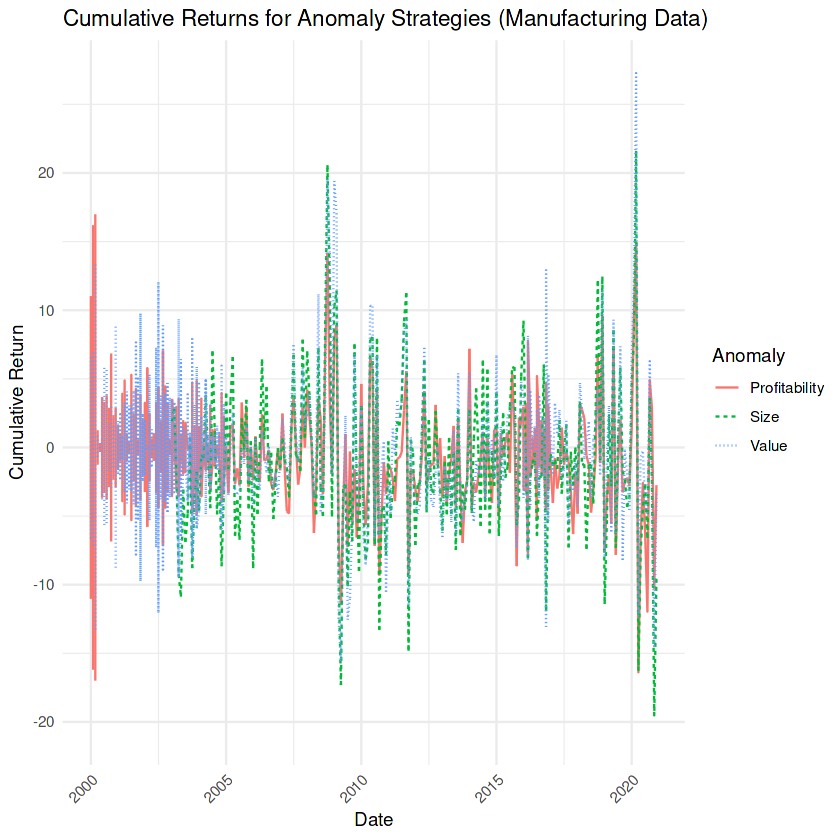

In [32]:
# Cumulative return columns (profitability_ret, size_ret, value_ret)
ggplot(merged_data, aes(x = date)) +
  geom_line(aes(y = profitability_ret, color = "Profitability")) +
  geom_line(aes(y = size_ret, color = "Size"), linetype = "dashed") +
  geom_line(aes(y = value_ret, color = "Value"), linetype = "dotted") +
  labs(title = "Cumulative Returns for Anomaly Strategies (Manufacturing Data)",
       x = "Date", y = "Cumulative Return", color = "Anomaly") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels

In [33]:
# Prepare data in a long format
analysis_data <- merged_data %>%
  select(date, profitability_ret, size_ret, value_ret) %>%
  pivot_longer(cols = c(profitability_ret, size_ret, value_ret),
               names_to = "strategy", values_to = "returns")

analysis_data_clean <- analysis_data %>%
  filter(!is.na(returns)) %>%  # Remove rows with missing returns
  arrange(date)

In [34]:
# Calculate the mean return, standard deviation, and Sharpe ratio manually
analysis_data_clean %>%
  group_by(strategy) %>%
  summarise(
    mean_return = mean(returns, na.rm = TRUE),  # Average return
    volatility = sd(returns, na.rm = TRUE),  # Standard deviation (Volatility)
    sharpe_ratio = mean(returns, na.rm = TRUE) / sd(returns, na.rm = TRUE)  # Sharpe ratio
  )

strategy,mean_return,volatility,sharpe_ratio
<chr>,<dbl>,<dbl>,<dbl>
profitability_ret,-0.7702508,4.305896,-0.1788828
size_ret,-0.7234412,6.323102,-0.1144124
value_ret,-0.5935221,5.386667,-0.1101836
